# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

# --- this part is required for mac --- #
import sys, os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from src.Datasets.batching import BatchManager

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Choose NCars or NCaltech-101 Dataset

In [2]:
from Datasets.ncaltech101 import NCaltech
from Datasets.ncars import NCars

# options: 'ncars' or 'ncaltech'
# dataset = 'ncars'  
dataset = 'ncaltech'

if dataset == 'ncars':
    num_classes = len(NCars.get_info().classes)
    image_size: tuple[int, int] = NCars.get_info().image_size  # (height=240, width=180)
if dataset == 'ncaltech':
    num_classes = len(NCaltech.get_info().classes)
    image_size: tuple[int, int] = NCaltech.get_info().image_size  # (height=240, width=180)

# Model Initialization

In [3]:
from src.Models.CleanEvGNN.recognition import RecognitionModel as EvGNN
from torch_geometric.data import Data as PyGData
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape: tuple[int, int, int] = (*image_size, 3)

# Vertausche Dimensionen: pos ist [x, y] = [width, height], also übergeben wir (width, height)
img_shape_for_model = (image_size[1], image_size[0])  # (180, 240) statt (240, 180)

evgnn = EvGNN(
    network="graph_res",
    dataset=dataset,
    num_classes = num_classes,
    img_shape=img_shape_for_model,  # (width=180, height=240)
    dim=3,
    conv_type="fuse",
    distill=False,        # <– no KD, just normal training
).to(device)


def transform_graph(graph: PyGData) -> PyGData:
    return evgnn.data_transform(
        graph, n_samples=25000, sampling=True,
        beta=0.5e-5, radius=5.0,
        max_neighbors=32
    ).to(device)

/Users/mielgeraats/miniconda3/envs/GNNBenchmark/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [4]:
#Instantiating the ncaltech dataset
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/N-Caltech101',
        transform=transform_graph
    )
if dataset == 'ncars':
    dataset_obj = NCars(
        #root=r"C:\Users\hanne\Documents\Hannes\Uni\Maastricht\Project\Datasets",
        root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/Prophesee_Dataset_n_cars',
        transform=transform_graph
)

# Processing the training part of the dataset
dataset_obj.process(modes = ["training"])

x

📂 Processing folder: gerenuk


gerenuk:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: hawksbill


hawksbill:   0%|          | 0/100 [00:00<?, ?it/s]


📂 Processing folder: headphone


headphone:   0%|          | 0/42 [00:00<?, ?it/s]


📂 Processing folder: ant


ant:   0%|          | 0/42 [00:00<?, ?it/s]


📂 Processing folder: butterfly


butterfly:   0%|          | 0/91 [00:00<?, ?it/s]


📂 Processing folder: lamp


lamp:   0%|          | 0/61 [00:00<?, ?it/s]


📂 Processing folder: strawberry


strawberry:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: water_lilly


water_lilly:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: chandelier


chandelier:   0%|          | 0/107 [00:00<?, ?it/s]


📂 Processing folder: dragonfly


dragonfly:   0%|          | 0/68 [00:00<?, ?it/s]


📂 Processing folder: crab


crab:   0%|          | 0/73 [00:00<?, ?it/s]


📂 Processing folder: pagoda


pagoda:   0%|          | 0/47 [00:00<?, ?it/s]


📂 Processing folder: dollar_bill


dollar_bill:   0%|          | 0/52 [00:00<?, ?it/s]


📂 Processing folder: emu


emu:   0%|          | 0/53 [00:00<?, ?it/s]


📂 Processing folder: inline_skate


inline_skate:   0%|          | 0/31 [00:00<?, ?it/s]


📂 Processing folder: platypus


platypus:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: dalmatian


dalmatian:   0%|          | 0/67 [00:00<?, ?it/s]


📂 Processing folder: cup


cup:   0%|          | 0/57 [00:00<?, ?it/s]


📂 Processing folder: airplanes


airplanes:   0%|          | 0/800 [00:00<?, ?it/s]


📂 Processing folder: joshua_tree


joshua_tree:   0%|          | 0/64 [00:00<?, ?it/s]


📂 Processing folder: cougar_body


cougar_body:   0%|          | 0/47 [00:00<?, ?it/s]


📂 Processing folder: grand_piano


grand_piano:   0%|          | 0/99 [00:00<?, ?it/s]


📂 Processing folder: trilobite


trilobite:   0%|          | 0/86 [00:00<?, ?it/s]


📂 Processing folder: brontosaurus


brontosaurus:   0%|          | 0/43 [00:00<?, ?it/s]


📂 Processing folder: wild_cat


wild_cat:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: pigeon


pigeon:   0%|          | 0/45 [00:00<?, ?it/s]


📂 Processing folder: dolphin


dolphin:   0%|          | 0/65 [00:00<?, ?it/s]


📂 Processing folder: soccer_ball


soccer_ball:   0%|          | 0/64 [00:00<?, ?it/s]


📂 Processing folder: wrench


wrench:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: scorpion


scorpion:   0%|          | 0/84 [00:00<?, ?it/s]


📂 Processing folder: flamingo_head


flamingo_head:   0%|          | 0/45 [00:00<?, ?it/s]


📂 Processing folder: nautilus


nautilus:   0%|          | 0/55 [00:00<?, ?it/s]


📂 Processing folder: accordion


accordion:   0%|          | 0/55 [00:00<?, ?it/s]


📂 Processing folder: cougar_face


cougar_face:   0%|          | 0/69 [00:00<?, ?it/s]


📂 Processing folder: pyramid


pyramid:   0%|          | 0/57 [00:00<?, ?it/s]


📂 Processing folder: camera


camera:   0%|          | 0/50 [00:00<?, ?it/s]


📂 Processing folder: barrel


barrel:   0%|          | 0/47 [00:00<?, ?it/s]


📂 Processing folder: schooner


schooner:   0%|          | 0/63 [00:00<?, ?it/s]


📂 Processing folder: cellphone


cellphone:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: panda


panda:   0%|          | 0/38 [00:00<?, ?it/s]


📂 Processing folder: revolver


revolver:   0%|          | 0/82 [00:00<?, ?it/s]


📂 Processing folder: lobster


lobster:   0%|          | 0/41 [00:00<?, ?it/s]


📂 Processing folder: menorah


menorah:   0%|          | 0/87 [00:00<?, ?it/s]


📂 Processing folder: lotus


lotus:   0%|          | 0/66 [00:00<?, ?it/s]


📂 Processing folder: stapler


stapler:   0%|          | 0/45 [00:00<?, ?it/s]


📂 Processing folder: crocodile


crocodile:   0%|          | 0/50 [00:00<?, ?it/s]


📂 Processing folder: chair


chair:   0%|          | 0/62 [00:00<?, ?it/s]


📂 Processing folder: helicopter


helicopter:   0%|          | 0/88 [00:00<?, ?it/s]


📂 Processing folder: minaret


minaret:   0%|          | 0/76 [00:00<?, ?it/s]


📂 Processing folder: starfish


starfish:   0%|          | 0/86 [00:00<?, ?it/s]


📂 Processing folder: ceiling_fan


ceiling_fan:   0%|          | 0/47 [00:00<?, ?it/s]


📂 Processing folder: ketch


ketch:   0%|          | 0/114 [00:00<?, ?it/s]


📂 Processing folder: mayfly


mayfly:   0%|          | 0/40 [00:00<?, ?it/s]


📂 Processing folder: wheelchair


wheelchair:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: bass


bass:   0%|          | 0/54 [00:00<?, ?it/s]


📂 Processing folder: yin_yang


yin_yang:   0%|          | 0/60 [00:00<?, ?it/s]


📂 Processing folder: crocodile_head


crocodile_head:   0%|          | 0/51 [00:00<?, ?it/s]


📂 Processing folder: saxophone


saxophone:   0%|          | 0/40 [00:00<?, ?it/s]


📂 Processing folder: beaver


beaver:   0%|          | 0/46 [00:00<?, ?it/s]


📂 Processing folder: mandolin


mandolin:   0%|          | 0/43 [00:00<?, ?it/s]


📂 Processing folder: bonsai


bonsai:   0%|          | 0/128 [00:00<?, ?it/s]


📂 Processing folder: Leopards


Leopards:   0%|          | 0/200 [00:00<?, ?it/s]


📂 Processing folder: car_side


car_side:   0%|          | 0/123 [00:00<?, ?it/s]


📂 Processing folder: ibis


ibis:   0%|          | 0/80 [00:00<?, ?it/s]


📂 Processing folder: electric_guitar


electric_guitar:   0%|          | 0/75 [00:00<?, ?it/s]


📂 Processing folder: kangaroo


kangaroo:   0%|          | 0/86 [00:00<?, ?it/s]


📂 Processing folder: stegosaurus


stegosaurus:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: ferry


ferry:   0%|          | 0/67 [00:00<?, ?it/s]


📂 Processing folder: snoopy


snoopy:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: umbrella


umbrella:   0%|          | 0/75 [00:00<?, ?it/s]


📂 Processing folder: rhino


rhino:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: okapi


okapi:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: watch


watch:   0%|          | 0/239 [00:00<?, ?it/s]


📂 Processing folder: brain


brain:   0%|          | 0/98 [00:00<?, ?it/s]


📂 Processing folder: gramophone


gramophone:   0%|          | 0/51 [00:00<?, ?it/s]


📂 Processing folder: scissors


scissors:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: rooster


rooster:   0%|          | 0/49 [00:00<?, ?it/s]


📂 Processing folder: cannon


cannon:   0%|          | 0/43 [00:00<?, ?it/s]


📂 Processing folder: binocular


binocular:   0%|          | 0/33 [00:00<?, ?it/s]


📂 Processing folder: anchor


anchor:   0%|          | 0/42 [00:00<?, ?it/s]


📂 Processing folder: octopus


octopus:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: buddha


buddha:   0%|          | 0/85 [00:00<?, ?it/s]


📂 Processing folder: laptop


laptop:   0%|          | 0/81 [00:00<?, ?it/s]


📂 Processing folder: windsor_chair


windsor_chair:   0%|          | 0/56 [00:00<?, ?it/s]


📂 Processing folder: hedgehog


hedgehog:   0%|          | 0/54 [00:00<?, ?it/s]


📂 Processing folder: pizza


pizza:   0%|          | 0/53 [00:00<?, ?it/s]


📂 Processing folder: euphonium


euphonium:   0%|          | 0/64 [00:00<?, ?it/s]


📂 Processing folder: stop_sign


stop_sign:   0%|          | 0/64 [00:00<?, ?it/s]


📂 Processing folder: Motorbikes


Motorbikes:   0%|          | 0/798 [00:00<?, ?it/s]


📂 Processing folder: sea_horse


sea_horse:   0%|          | 0/57 [00:00<?, ?it/s]


📂 Processing folder: flamingo


flamingo:   0%|          | 0/67 [00:00<?, ?it/s]


📂 Processing folder: ewer


ewer:   0%|          | 0/85 [00:00<?, ?it/s]


📂 Processing folder: garfield


garfield:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: crayfish


crayfish:   0%|          | 0/70 [00:00<?, ?it/s]


📂 Processing folder: Faces_easy


Faces_easy:   0%|          | 0/435 [00:00<?, ?it/s]


📂 Processing folder: sunflower


sunflower:   0%|          | 0/85 [00:00<?, ?it/s]


📂 Processing folder: llama


llama:   0%|          | 0/78 [00:00<?, ?it/s]


📂 Processing folder: elephant


elephant:   0%|          | 0/64 [00:00<?, ?it/s]


📂 Processing folder: tick


tick:   0%|          | 0/49 [00:00<?, ?it/s]


📂 Processing folder: metronome


metronome:   0%|          | 0/32 [00:00<?, ?it/s]

Display example events data point

In [5]:
training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=8,
    mode="training"
)

In [6]:
optimizer = Adam(evgnn.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
loss_fn = CrossEntropyLoss()

classes = dataset_obj.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [7]:
def label_to_index(lbl):
    if isinstance(lbl,str): # for n-caltech labels (strings)
        return cls_to_idx[lbl]
    if isinstance(lbl, torch.Tensor): # for ncars labels (tensors)
        return int(lbl.item())  

In [8]:
evgnn.train()
losses = []

for i in range(1000):
    optimizer.zero_grad() 

    examples = next(training_set)
    reference = torch.tensor([label_to_index(lbl) for lbl in examples.label], dtype=torch.long).to(device)
    out = evgnn(examples)
    loss = loss_fn(out, reference)
    loss.backward()

    # Gradient Clipping für Stabilität
    torch.nn.utils.clip_grad_norm_(evgnn.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()

    current_lr = scheduler.get_last_lr()[0]
    print(f"Iteration {i:3d} | Loss: {loss.item():.4f} | LR: {current_lr:.6f}")
    losses.append(loss.item())
torch.save(evgnn.state_dict(), f"evgnn_{dataset}_test.pth")
# i removed the time window in the data_transform function to make it work with ncaltech, mybe that could be a problem

Iteration   0 | Loss: 5.0679 | LR: 0.000010
Iteration   1 | Loss: 5.2075 | LR: 0.000010
Iteration   2 | Loss: 5.6466 | LR: 0.000010
Iteration   3 | Loss: 4.9553 | LR: 0.000010
Iteration   4 | Loss: 5.1594 | LR: 0.000010
Iteration   5 | Loss: 4.6731 | LR: 0.000010
Iteration   6 | Loss: 4.9989 | LR: 0.000010
Iteration   7 | Loss: 4.7198 | LR: 0.000010
Iteration   8 | Loss: 4.9909 | LR: 0.000010
Iteration   9 | Loss: 4.8671 | LR: 0.000010
Iteration  10 | Loss: 4.6957 | LR: 0.000010
Iteration  11 | Loss: 5.1659 | LR: 0.000010
Iteration  12 | Loss: 5.0807 | LR: 0.000010
Iteration  13 | Loss: 5.1249 | LR: 0.000010
Iteration  14 | Loss: 4.8310 | LR: 0.000010
Iteration  15 | Loss: 5.1264 | LR: 0.000010
Iteration  16 | Loss: 5.5020 | LR: 0.000010
Iteration  17 | Loss: 4.7516 | LR: 0.000010
Iteration  18 | Loss: 4.5526 | LR: 0.000010
Iteration  19 | Loss: 4.6426 | LR: 0.000010
Iteration  20 | Loss: 4.5483 | LR: 0.000010
Iteration  21 | Loss: 4.3009 | LR: 0.000010
Iteration  22 | Loss: 4.5604 | L

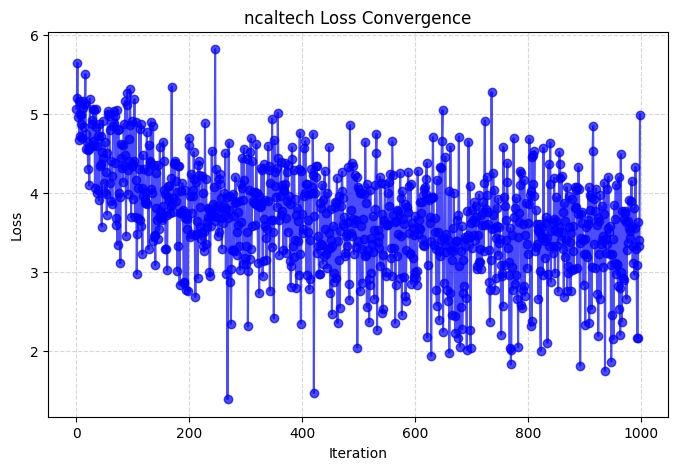

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, title=f"{dataset} Loss Convergence", xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    plt.figure(figsize=(8,5))
    plt.plot(loss_list, marker='o', linestyle='-', color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_loss_convergence(losses)